# Project: CIFAR-10 이미지 생성하기
- Image Generation
- DCGAN

In [171]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## 데이터셋 구성

In [172]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape # (60000, 28, 28)

(50000, 32, 32, 3)

In [173]:
print("max pixel:", train_x.max()) # 255
print("min pixel:", train_x.min()) # 0

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0


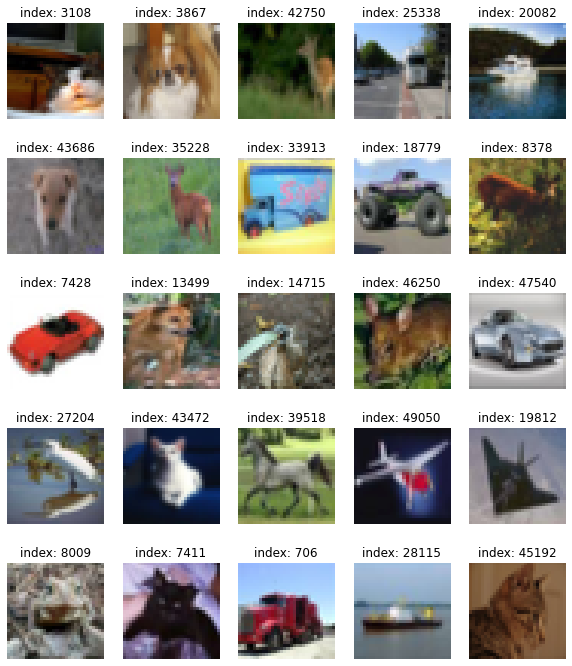

In [174]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1) / 2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [175]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현

In [176]:
def make_generator_model(momentum=0.9, alpha=0.2, dr_rate=0.4):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
#     model.add(layers.Dropout(dr_rate))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [177]:
generator = make_generator_model()

generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 8, 8, 128)       

In [178]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

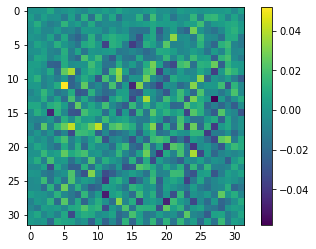

In [179]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## 판별자 모델 구현

In [180]:
def make_discriminator_model(alpha=0.2, dr_rate=0.3):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dr_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dr_rate))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [181]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)           

In [182]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00090483]], dtype=float32)>

## 손실함수와 최적화 함수 구현

In [183]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


In [184]:
lr1 = 1e-4
lr2 = 5e-4
generator_optimizer = tf.keras.optimizers.Adam(lr1, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr2, beta_1=0.5)

In [185]:
# 샘플
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세기능 구현

In [186]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [187]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [188]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [189]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습 과정 진행

In [190]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [191]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

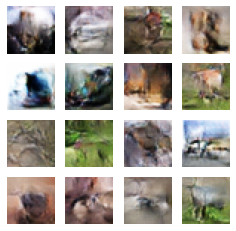

Time for training : 2921 sec


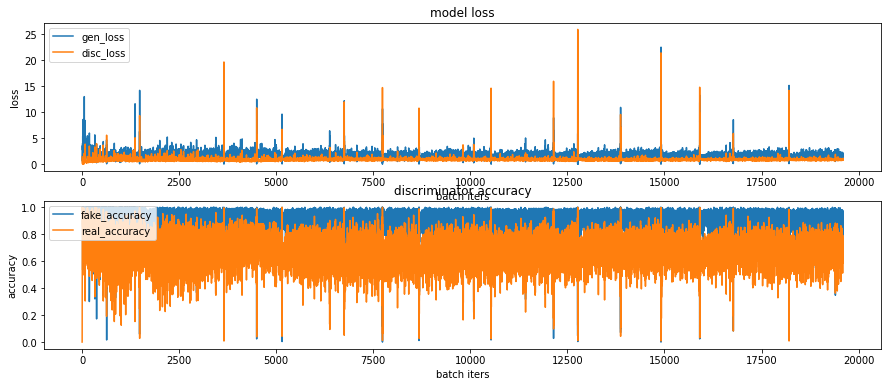

CPU times: user 48min 47s, sys: 2min 42s, total: 51min 29s
Wall time: 48min 43s


In [192]:
%%time
train(train_dataset, EPOCHS, save_every)

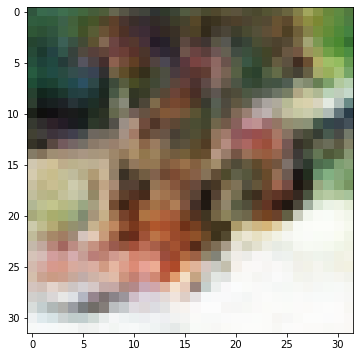

In [194]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [195]:
save_every = 5
EPOCHS = 50

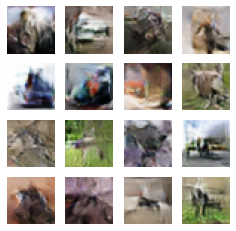

Time for training : 1435 sec


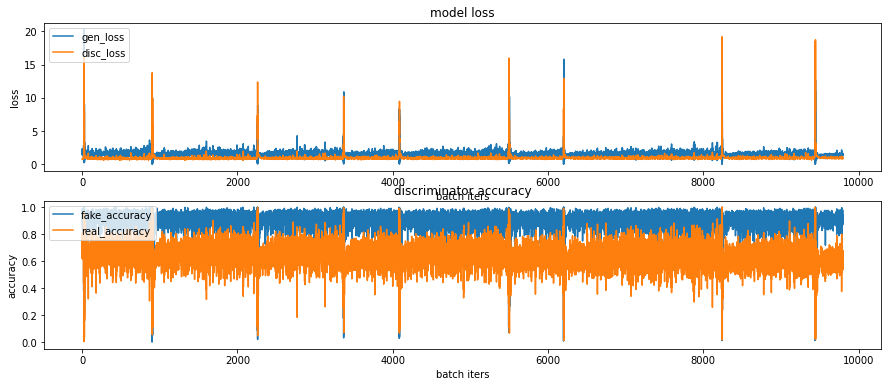

CPU times: user 24min 6s, sys: 1min 20s, total: 25min 27s
Wall time: 23min 56s


In [196]:
%%time
train(train_dataset, EPOCHS, save_every)

## 학습 과정 시각화

In [193]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1443297 Apr 30 16:59 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


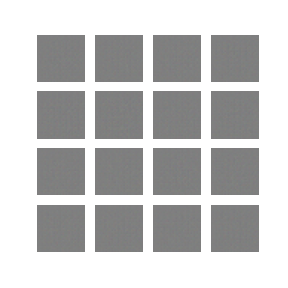

In [199]:
display.Image(filename="./cifar10/cifar10_dcgan.gif",  width=400, height=400)

## Experiments

1. 별다른 하이퍼파라미터 지정하지 않고 shape만 맞게 바꿔줌


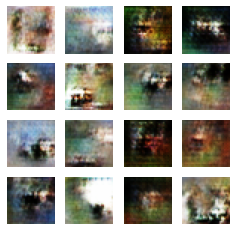

Time for training : 2789 sec


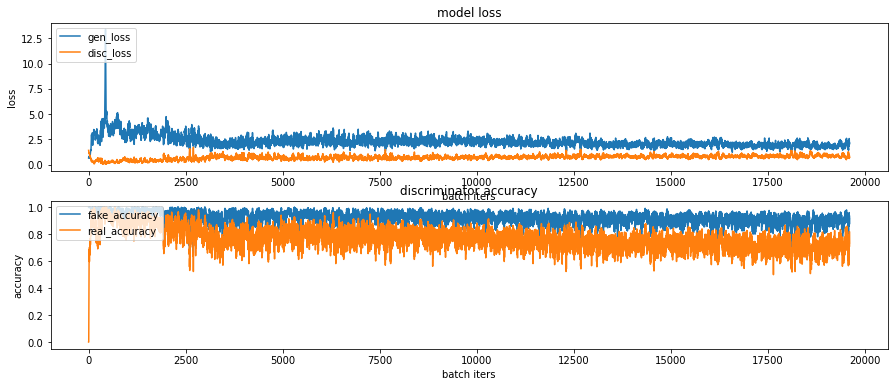

CPU times: user 46min 58s, sys: 2min 45s, total: 49min 43s
Wall time: 46min 31s


In [22]:
# 100 epoch
%%time
train(train_dataset, EPOCHS, save_every)

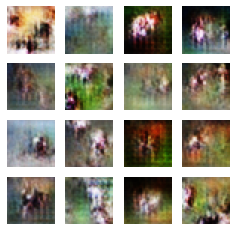

Time for training : 1369 sec


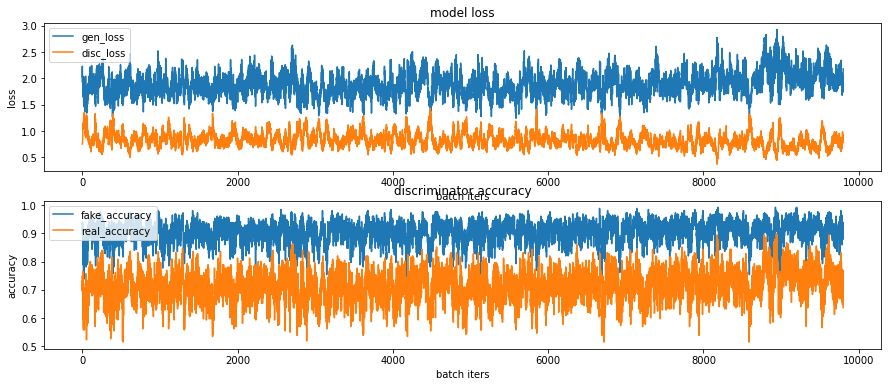

CPU times: user 23min 6s, sys: 1min 20s, total: 24min 26s
Wall time: 22min 50s


In [25]:
# 150 epoch
%%time
train(train_dataset, EPOCHS, save_every)

150 epoch 돌린 결과 loss가 크게 떨어지는 모습이 보이진 않는다. accuracy 또한 특정 구간에서 머물러 있고, 생성된 이미지도 노이즈는 아니지만 형태를 알아볼 수 있을 정도는 아니다. 하이퍼파라미터 조정이 필요해보인다.

2. 하이퍼파라미터 변경
- generator에 dropout 추가 (dropout rate=0.4)
- batchnormalization에 momentum 추가 (0.9)
- leakyReLU에 alpha 추가 (0.2)
- learning rate 5e-4 (둘 다)

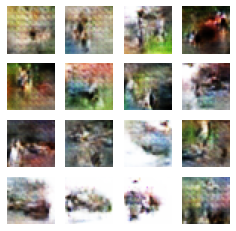

Time for training : 2834 sec


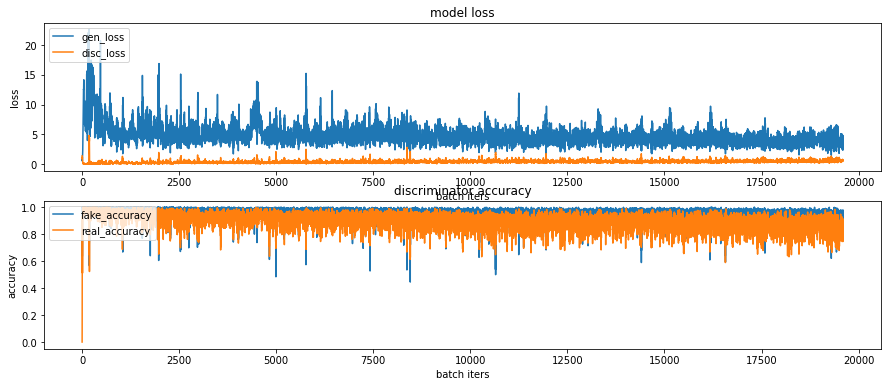

CPU times: user 47min 36s, sys: 2min 42s, total: 50min 19s
Wall time: 47min 15s


In [22]:
# 100 epoch
%%time
train(train_dataset, EPOCHS, save_every)

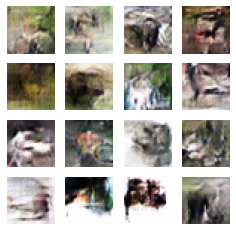

Time for training : 1411 sec


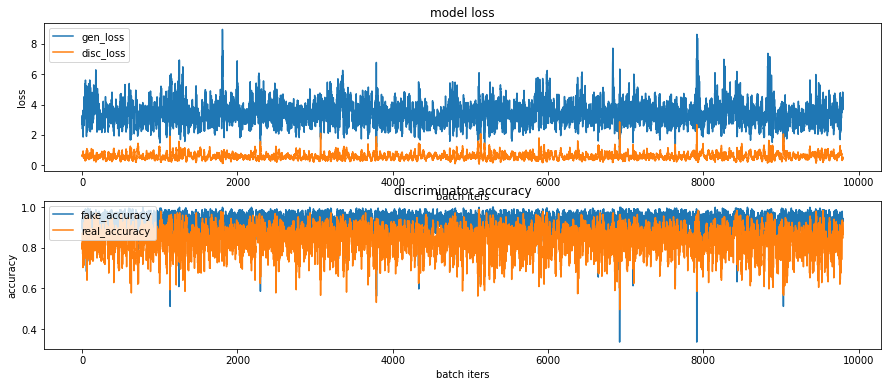

CPU times: user 23min 45s, sys: 1min 20s, total: 25min 6s
Wall time: 23min 32s


In [27]:
# 200 epoch
%%time
train(train_dataset, EPOCHS, save_every)

loss가 훅 떨어진 후로 거의 수렴한 느낌이고, accuracy도 큰 변동이 없이 큰 값에 머물러 있다. 하이퍼파라미터를 변경할 필요성이 있다.

3. 하이퍼파라미터 변경
- generator에 dropout 추가 (dropout rate=0.4)
- discriminator dropout 변경 (0.3 -> 0.4)
- batchnormalization에 momentum 추가 (0.9)
- leakyReLU에 alpha 추가 (0.2)
- learning rate 다르게 (generator 5e-4, discriminator 1e-3)
- Adam optimizer에 beta_1=0.5 추가

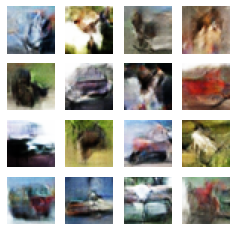

Time for training : 2953 sec


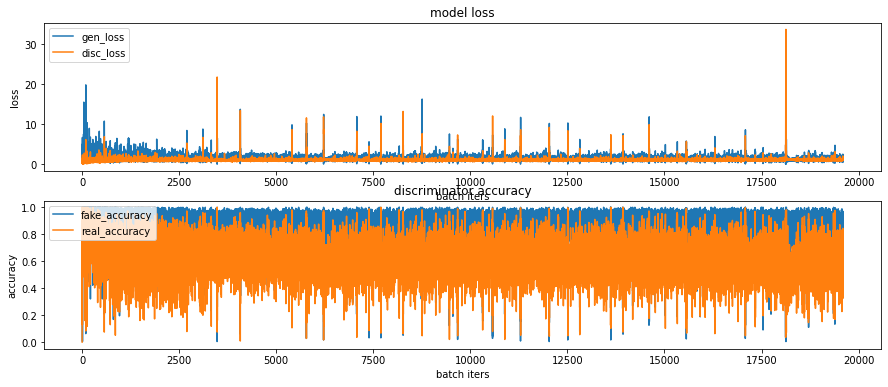

CPU times: user 49min 31s, sys: 2min 43s, total: 52min 15s
Wall time: 49min 15s


In [67]:
%%time
train(train_dataset, EPOCHS, save_every)

샘플 이미지는 얼추 cifar-10과 비슷하게 나왔다. real accuracy는 0.5에 가깝게 떨어진 것 같은데 fake accuracy는 덜 떨어져서 아쉽게 나왔다.

4. 하이퍼파라미터 변경
- batchnormalization에 momentum 추가 (0.9)
- leakyReLU에 alpha 추가 (0.2)
- learning rate 다르게 (generator 1e-4, discriminator 5e-4)
- Adam optimizer에 beta_1=0.5 추가

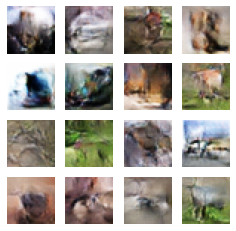

Time for training : 2921 sec


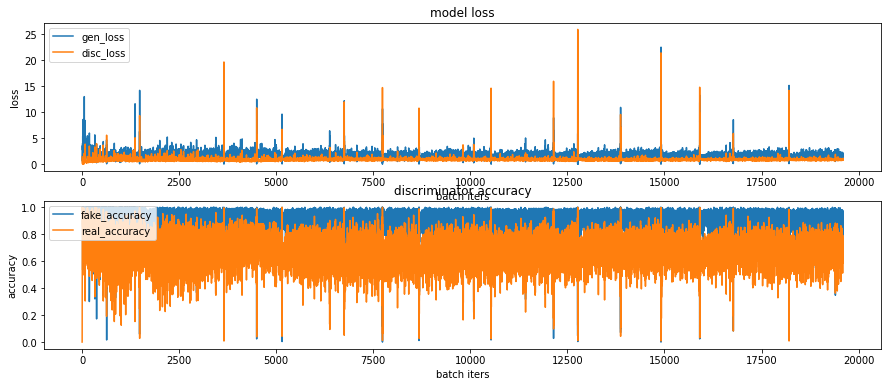

CPU times: user 48min 47s, sys: 2min 42s, total: 51min 29s
Wall time: 48min 43s


In [192]:
# 100 epoch
%%time
train(train_dataset, EPOCHS, save_every)

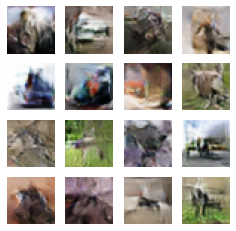

Time for training : 1435 sec


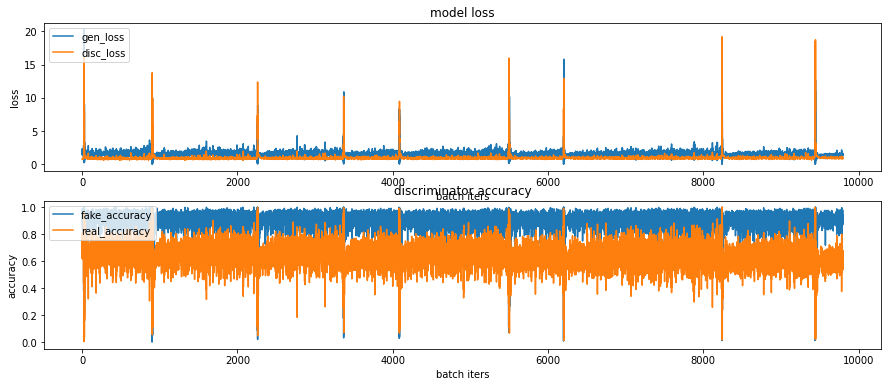

CPU times: user 24min 6s, sys: 1min 20s, total: 25min 27s
Wall time: 23min 56s


In [196]:
# 150 epoch
%%time
train(train_dataset, EPOCHS, save_every)

샘플 이미지는 만족스럽지는 않지만 얼추 cifar-10과 비슷하게 나왔다. real accuracy는 0.5에 가깝게 떨어진 것 같은데 fake accuracy는 덜 떨어져서 아쉽게 나왔다. 하지만 3번 실험과 비교해서 accuracy의 분산이 더 작게 나왔다. <br>
50 epoch를 더 돌렸을 때 accuracy가 좀 더 떨어졌고, 결과도 조금 더 선명하게 나왔다.

## 회고

- 위의 실험 외에도 다양한 실험을 해봤다. [링크](https://github.com/soumith/ganhacks)에서 discriminator의 optimizer를 SGD로 써보라고 해서 써봤지만, SGD를 썼을 때는 학습이 아예 되지 않았다. 다른 하이퍼파라미터가 원인일지 아니면 다른 원인이 있을지 파악해볼 필요성이 있다.
- 하이퍼파라미터 튜닝의 중요성을 다시 한 번 깨달았다. 더 나은 조합을 찾으면 더 나은 성능을 기대할 수 있을 것 같다.
- 시간 관계 상 더 많은 조합을 실험해보지는 못해서 아쉽다.